# Cell Balancing using a Genetic Algorithm

## Problem Statement

- Our study has a global "Audience" (demographic) set that needs to be fulfilled.
- We have a limited number of Highlighters.
- In our study, we have Cells (pairing of instructions <-> audience)
- It's possible for the audiences of each Cell to overlap.
- We therefore have a constraint satisfaction problem. Given a finite list of Highlighters, how do we distribute those Highlighters to Cells so that we maximize our distribution and minimize our chance of not being able to fill one of the Cells?

## Defining Classes and Configuration:

In [13]:
import random 

class Highlighter:
    def __init__(self, name):
        self.name = name
        self.assignable_buckets = []

    def __str__(self):
        return f"Highlighter: {self.name}, assignable_buckets: {self.assignable_buckets}"

# Buckets are what we need to fill.
class Bucket:
    def __init__(self, name, percent_fillable, fill_goal):
        self.name = name
        # How many of the available Highlighters can fit into this bucket
        self.percent_fillable = percent_fillable
        self.highlighters = []
        # How many Highlighters are needed to fill that bucket
        self.fill_goal = fill_goal

    def score(self):
        return 1

# Things to configure
buckets = [
    Bucket("A", 20, 10),
    Bucket("B", 20, 20),
    Bucket("C", 60, 30),
    Bucket("D", 30, 30),
    Bucket("E", 10, 10),
]

NUM_HIGHLIGHTERS = 100

highlighters = [Highlighter(f"H_{i:03d}") for i in range(NUM_HIGHLIGHTERS)]

# Configure randomly which Highlighters can be assigned to which buckets
for bucket in buckets:
    fillable = bucket.percent_fillable / 100.0
    num_highlighters_to_assign = int(NUM_HIGHLIGHTERS * fillable)
    
    hlers_to_add_bucket_to = random.sample(highlighters, num_highlighters_to_assign)
    for h in hlers_to_add_bucket_to:
        h.assignable_buckets.append(bucket.name)

for h in highlighters:
    print(h)

# filter out highlighters that have no possible assignment
highlighters = [h for h in highlighters if len(h.assignable_buckets) > 0]


Highlighter: H_000, assignable_buckets: []
Highlighter: H_001, assignable_buckets: ['C']
Highlighter: H_002, assignable_buckets: ['B', 'C', 'E']
Highlighter: H_003, assignable_buckets: ['D']
Highlighter: H_004, assignable_buckets: ['B', 'C']
Highlighter: H_005, assignable_buckets: ['B', 'C']
Highlighter: H_006, assignable_buckets: []
Highlighter: H_007, assignable_buckets: ['A', 'B']
Highlighter: H_008, assignable_buckets: ['B', 'C']
Highlighter: H_009, assignable_buckets: ['B', 'C']
Highlighter: H_010, assignable_buckets: ['C']
Highlighter: H_011, assignable_buckets: ['C', 'D']
Highlighter: H_012, assignable_buckets: ['C']
Highlighter: H_013, assignable_buckets: ['C', 'D']
Highlighter: H_014, assignable_buckets: []
Highlighter: H_015, assignable_buckets: ['C', 'D']
Highlighter: H_016, assignable_buckets: ['A', 'C', 'D', 'E']
Highlighter: H_017, assignable_buckets: ['C']
Highlighter: H_018, assignable_buckets: ['C', 'D']
Highlighter: H_019, assignable_buckets: ['A', 'D']
Highlighter: H

## Visualizing the Buckets

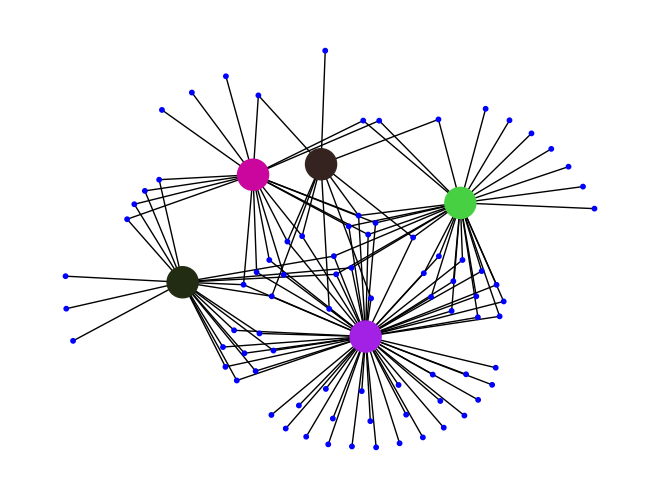

In [14]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a graph
G = nx.Graph()

# Add highlighters as nodes
for highlighter in highlighters:
    G.add_node(highlighter.name, type='highlighter')

bucket_colors = {}
for bucket in buckets:
    color = (random.random(), random.random(), random.random())  # Random RGB color
    bucket_colors[bucket.name] = color
    G.add_node(bucket.name, type='bucket', color=color)
    for highlighter in highlighters:
        if bucket.name in highlighter.assignable_buckets:
            G.add_edge(highlighter.name, bucket.name)

# Draw the graph
# pos = nx.spring_layout(G)
# pos = nx.circular_layout(G)
# pos = nx.spectral_layout(G)
pos = nx.kamada_kawai_layout(G)

node_types = nx.get_node_attributes(G, 'type')
node_sizes = [500 if node_types[node] == 'bucket' else 10 for node in G.nodes]  # Larger size for buckets

node_colors = [bucket_colors[node] if node_types[node] == 'bucket' else 'blue' for node in G.nodes]

nx.draw(G, pos, with_labels=False, node_color=node_colors, node_size=node_sizes)
plt.show()

## Defining a Fitness Function

Our fitness function needs to somewhat accurately define what a "good" assignment is.

"Good" means:
- High percentage of filled buckets

In [15]:
import statistics 

# Fitness function that just optimizes for
# total percentage of assigned Highlighters
def fitness_1(buckets, assignment):
    '''
        buckets: []Bucket
        assignments: dict {Highlighter: Bucket_Name}

    '''

    assigned_buckets = list(assignment.values())

    fill_ratios = []
    for bucket in buckets:
        num_filled = sum(1 for assigned_bucket in assigned_buckets if assigned_bucket == bucket.name)
        fill_ratios.append(min(num_filled / bucket.fill_goal, 1.0))

    return statistics.mean(fill_ratios)

# Same as fitness_1 except it penalizes for overfilling buckets
def fitness_2(buckets, assignment):
    '''
        buckets: []Bucket
        assignments: dict {Highlighter: Bucket_Name}
    '''

    assigned_buckets = list(assignment.values())

    fill_ratios = []
    for bucket in buckets:
        num_filled = sum(1 for assigned_bucket in assigned_buckets if assigned_bucket == bucket.name)
        fill_ratio = num_filled / bucket.fill_goal
        if fill_ratio > 1.0:
            # Apply penalty for fill ratios greater than 1
            penalty = 1.0 - (fill_ratio - 1.0)
            fill_ratios.append(penalty)
        else:
            fill_ratios.append(fill_ratio)

    return statistics.mean(fill_ratios)



def fitness_3(buckets, assignments):
    """
    Calculate the fitness score based on the total number of assigned highlighters divided by the sum of bucket fill goals.
    
    :param buckets: List of Bucket objects
    :param assignments: Dictionary mapping Highlighter objects to bucket names
    :return: Fitness score
    """
    total_assigned_highlighters = len(assignments)
    total_fill_goals = sum(bucket.fill_goal for bucket in buckets)
    
    # Avoid division by zero
    if total_fill_goals == 0:
        return 0.0
    
    # Calculate fitness score
    fitness_score = total_assigned_highlighters / total_fill_goals
    
    return fitness_score
    

## Assignment Generation

### Random

In [16]:
import random
def generate_random_assignment(buckets, highlighters):
    '''
        Each Highlighter can only be assigned to 1 Bucket.
    '''
    assignment = {}
    for h in highlighters:
        # Randomly choose one of the highlighter's assignable buckets
        chosen_bucket = random.choice(h.assignable_buckets)
        assignment[h] = chosen_bucket
    return assignment

assignment = generate_random_assignment(buckets, highlighters)

### Weighted Random Assignment - Prioritizes Fill Needs

In [17]:
import random

def generate_weighted_assignment(buckets, highlighters):
    '''
        Generate assignments based on Bucket needs with some degree of randomness.
        Each Highlighter can only be assigned to one of its assignable buckets.
    '''
    assignment = {}
    
    # Dictionary to keep track of total filled per bucket
    filled_per_bucket = {bucket.name: 0 for bucket in buckets}
    
    # Calculate total filled per bucket
    for h in highlighters:
        if h in assignment:
            filled_per_bucket[assignment[h]] += 1

    random.shuffle(highlighters)
    for h in highlighters:
        # Filter buckets to only include those that are assignable to the highlighter
        assignable_buckets = [bucket for bucket in buckets if bucket.name in h.assignable_buckets]

        # If there are no assignable buckets, skip assignment for this highlighter
        if not assignable_buckets:
            continue
        
        # Calculate remaining needs ratios for each bucket
        remaining_ratios = [(bucket.fill_goal - filled_per_bucket[bucket.name]) / bucket.fill_goal for bucket in assignable_buckets]
        
        # Calculate weights based on remaining needs ratios
        weights = remaining_ratios
        
        # Calculate cumulative weights
        cumulative_weights = [sum(weights[:i+1]) for i in range(len(weights))]
        
        # Choose a random number within the total weight
        rand_num = random.uniform(0, sum(weights))
        
        # Find the corresponding bucket based on the random number
        chosen_bucket = None
        for i, cum_weight in enumerate(cumulative_weights):
            if rand_num <= cum_weight:
                chosen_bucket = assignable_buckets[i]
                break
        if chosen_bucket:
            assignment[h] = chosen_bucket.name
        
            # Update total filled per bucket
            filled_per_bucket[chosen_bucket.name] += 1
        else:
            assignment[h] = ''
    return assignment

assignment = generate_weighted_assignment(buckets, highlighters)


## Visualize the Assignment

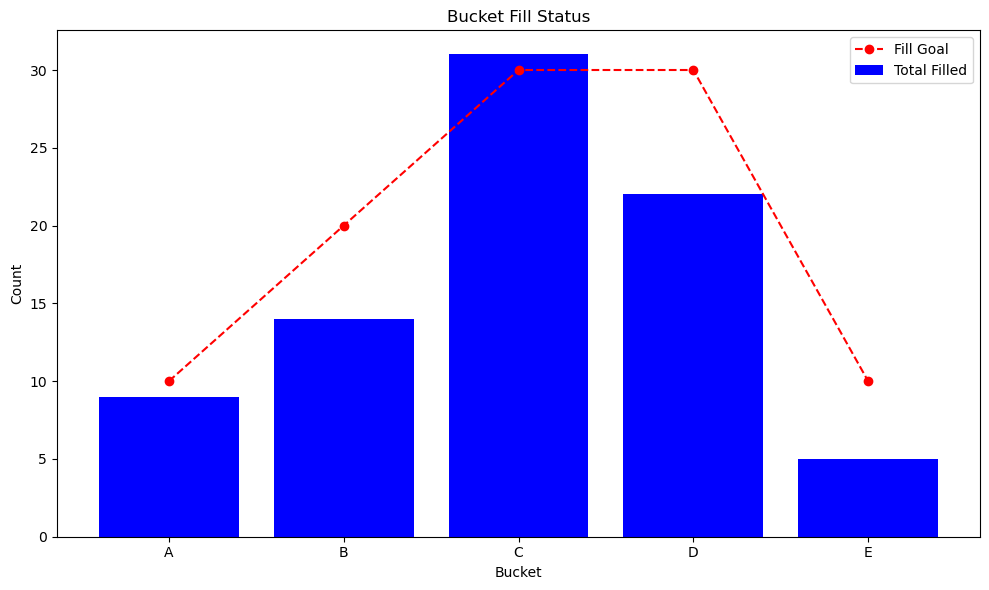

In [18]:
import matplotlib.pyplot as plt

def generate_bar_graphs(buckets, assignment):
    # Initialize lists to store fill goals and total filled for each bucket
    fill_goals = []
    total_filled = []

    # Iterate over each bucket to gather fill goals and calculate total filled
    for bucket in buckets:
        fill_goals.append(bucket.fill_goal)
        total_filled.append(sum(1 for assigned_bucket in assignment.values() if assigned_bucket == bucket.name))

    # Create bar graph
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(buckets)), total_filled, color='blue', label='Total Filled')
    plt.plot(fill_goals, color='red', linestyle='--', marker='o', label='Fill Goal')
    
    # Set labels and title
    plt.xlabel('Bucket')
    plt.ylabel('Count')
    plt.title('Bucket Fill Status')
    plt.xticks(range(len(buckets)), [bucket.name for bucket in buckets])
    plt.legend()
    plt.tight_layout()

    # Show plot
    plt.show()

generate_bar_graphs(buckets, assignment)


## Determine the Fitness of this Assignment

In [19]:
fitness_1(buckets, assignment)

0.7666666666666666

In [20]:
## Average Fitness of Random Assignment

scores = []
for i in range(1000):
    assignment = generate_random_assignment(buckets, highlighters)
    scores.append(fitness_1(buckets, assignment))

print(statistics.mean(scores))

0.70015


# Genetic Algorithm

In [21]:
class GeneticAlgorithmRunner:
    def __init__(self, buckets, highlighters, mutation_rate=0.01, crossover_rate=0.1, cull_rate=0.1, max_pop=1000, max_epochs=50, fitness_function = fitness_1, generator_algorithm=generate_random_assignment):
        self.buckets = buckets
        self.highlighters = highlighters
        self.assignments = []
        self.cull_rate = cull_rate
        self.mutation_rate = mutation_rate
        self.crossover_rate = crossover_rate
        self.max_epochs = max_epochs
        self.max_population = max_pop
        self.fitness_function = fitness_function
        self.generator_algorithm = generator_algorithm

        self.population = []
                # Generate N random assignments
        for i in range(self.max_population):
            self.population.append(generator_algorithm(self.buckets, self.highlighters))

            # Select some % of fitnesses based on weights
            # selected_indices = random.choices(range(len(fitnesses)), weights=weights, k=int(self.cull_rate * len(fitnesses)))

    # Selects the top candidates 
    def cull(self, fitnesses, population):
        # Determine the number of individuals to select
        num_to_select = int(len(fitnesses) * self.cull_rate)
        
        # Create a list of indices and fitnesses
        indexed_fitnesses = list(enumerate(fitnesses))
        
        # Sort by fitness in descending order
        indexed_fitnesses.sort(key=lambda x: x[1], reverse=True)
        
        # Extract the top individuals based on sorted fitness scores
        selected_indices = [idx for idx, _ in indexed_fitnesses[:num_to_select]]
        
        # Select the fitnesses and population members by these indices
        selected_fitnesses = [fitnesses[i] for i in selected_indices]
        selected_population = [population[i] for i in selected_indices]
        
        return selected_fitnesses, selected_population

    def increase_population(self):
        """
        Increase the current population by breeding - apply mutation and crossover.
        """
        # Calculate the number of individuals needed to reach the maximum population size
        num_individuals_needed = self.max_population - len(self.population)

        original_population = self.population
        
        # Generate new individuals until the population reaches the maximum size
        while len(self.population) < self.max_population:
            # Select two parents randomly from the current population
            parent1, parent2 = random.sample(original_population, 2)
            
            offspring = self.breed(parent1, parent2)
            
            # Add the offspring to the population
            self.population.append(offspring)

    # Mutate a given individual's genes
    def mutate(self, assignment):
        for highlighter, bucket in assignment.items():
            if random.random() < self.mutation_rate:
                assignment[highlighter] = random.choice(highlighter.assignable_buckets)
        return assignment

    def crossover(self, assignment1, assignment2):
        """
        Perform crossover between two parents to produce a new individual.
        
        :param assignment1: Dictionary representing the assignment of highlighters to buckets for parent 1
        :param assignment2: Dictionary representing the assignment of highlighters to buckets for parent 2
        :return: Dictionary representing the assignment of highlighters to buckets for the offspring
        """
        # Initialize the offspring assignment
        offspring_assignment = {}

        # Randomly select genes (highlighter-bucket pairs) from each parent
        for highlighter in assignment1:
            if random.random() < 0.5:  # 50% chance to inherit from parent 1
                offspring_assignment[highlighter] = assignment1[highlighter]
            else:  # 50% chance to inherit from parent 2
                offspring_assignment[highlighter] = assignment2[highlighter]

        return offspring_assignment
    
    def breed(self, assignment1, assignment2):
        child_assignment = {}

        # Randomly make child a copy of either parent1 or parent2
        if random.random() < 0.5:
            child_assignment = assignment1
        else:
            child_assignment = assignment2

        # Probability of getting both parent's genes
        if random.random() < self.crossover_rate:
            child_assignment = self.crossover(assignment1, assignment2)

        # Mutate the genes
        child_assignment = self.mutate(child_assignment)        

        return child_assignment

    def get_best(self):
        """
        Return the highest score of the individuals in the current population.
        """
        best_score = float('-inf')  # Initialize with negative infinity to find the maximum score
        best_assignment = None
        
        # Iterate over each individual in the population
        for assignment in self.population:
            # Calculate the fitness score for the individual using the provided fitness function
            score = self.fitness_function(self.buckets, assignment)
            
            # Update the best score if the current score is higher
            if score > best_score:
                best_score = score
                best_assignment = assignment
        
        return best_assignment, best_score
        
    def run(self):
        for i in range(self.max_epochs):
            # Evaluate their fitnesses
            scores = []
            for assignment in self.population:
                scores.append(self.fitness_function(self.buckets, assignment))
    
            # Cull the herd (survival of the fittest!)
            best_scores, best_assignments = self.cull(scores, self.population)
            self.population = best_assignments

            # Breed to restore the population 
            self.increase_population()

            print(f"Epoch: {i}, Best Score: {max(best_scores)}")

            if max(best_scores) >= .9999:
                break
        

In [22]:
# generator_algorithm = random_assignment
fitness_function = fitness_1
generator_algorithm = generate_random_assignment
max_population = 1000
max_epochs = 50

a = GeneticAlgorithmRunner(buckets, highlighters, mutation_rate=0.01, crossover_rate=1.0, fitness_function=fitness_function, generator_algorithm=generator_algorithm, max_pop=max_population, max_epochs=max_epochs)
a.run()

Epoch: 0, Best Score: 0.8133333333333334
Epoch: 1, Best Score: 0.8266666666666667
Epoch: 2, Best Score: 0.8566666666666667
Epoch: 3, Best Score: 0.8766666666666667
Epoch: 4, Best Score: 0.8766666666666667
Epoch: 5, Best Score: 0.8766666666666667
Epoch: 6, Best Score: 0.8766666666666667
Epoch: 7, Best Score: 0.8766666666666667
Epoch: 8, Best Score: 0.8766666666666667
Epoch: 9, Best Score: 0.8766666666666667
Epoch: 10, Best Score: 0.8766666666666667
Epoch: 11, Best Score: 0.8766666666666667
Epoch: 12, Best Score: 0.8766666666666667
Epoch: 13, Best Score: 0.8766666666666667
Epoch: 14, Best Score: 0.8766666666666667
Epoch: 15, Best Score: 0.8766666666666667
Epoch: 16, Best Score: 0.8766666666666667
Epoch: 17, Best Score: 0.8766666666666667
Epoch: 18, Best Score: 0.8766666666666667
Epoch: 19, Best Score: 0.8766666666666667
Epoch: 20, Best Score: 0.8766666666666667
Epoch: 21, Best Score: 0.8766666666666667
Epoch: 22, Best Score: 0.8766666666666667
Epoch: 23, Best Score: 0.8766666666666667
Ep

In [23]:
assignment, score = a.get_best()

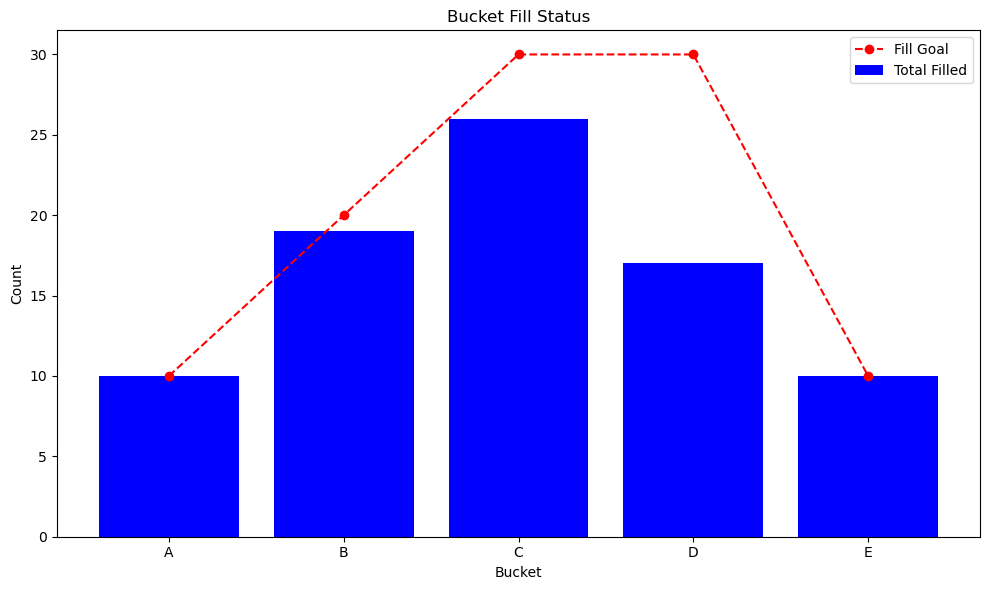

In [24]:
generate_bar_graphs(buckets, assignment)

In [25]:
score

0.8766666666666667